<b> <center> <font size=6 face = 'arial' color = 'red'> Logistic Regression </font></center> </b>

Data set chosen for implementing Logistic Regression is [Titanic Dataset](https://www.kaggle.com/c/titanic/data)

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#pd.set_option("display.max_columns",50)

In [4]:
path = "C:/Users/Krishna/Documents/kaggle/titanic/input"

##### Reading train file

In [5]:
train = pd.read_csv(f'{path}/train.csv')
train.head(2)
train.shape

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


(891, 12)

##### Reading test file

In [6]:
test = pd.read_csv(f'{path}/test.csv')
test.head(2)
test.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


(418, 11)

##### checking variables with null values

In [18]:
train[train.columns[train.isna().sum()>0]].isna().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

In [19]:
test[test.columns[test.isna().sum()>0]].isna().sum()

Age       86
Fare       1
Cabin    327
dtype: int64

In [20]:
#dropping cabin,name,ticket as these variables are not giving any significant information
train = train.drop(['Name', 'Ticket','Cabin'], axis = 1)
test = test.drop(['Name', 'Ticket','Cabin'], axis = 1)

##### imputing age on the basis of gender wise average age

In [23]:
train.groupby('Sex').Age.mean()
#checking genderwise count of passenger with missing age
train.Age.isna().groupby(train.Sex, sort = False).sum()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

Sex
male      124.0
female     53.0
Name: Age, dtype: float64

In [24]:
test.groupby('Sex').Age.mean()
#checking genderwise count of passenger with missing age
test.Age.isna().groupby(test.Sex, sort = False).sum()

Sex
female    30.272362
male      30.272732
Name: Age, dtype: float64

Sex
male      61.0
female    25.0
Name: Age, dtype: float64

##### imputing missing age for each gender with the mean age of that gender

In [25]:
train.loc[train.Age.isna(), 'Age'] = train[train.Age.isna()].Sex.map(train.groupby('Sex').Age.mean().to_dict())

In [14]:
test.loc[test.Age.isna(), 'Age'] = test[test.Age.isna()].Sex.map(train.groupby('Sex').Age.mean().to_dict())

##### treating NA in other columns

In [26]:
#imputing fare with mean fare for test 
test['Fare'] = test.Fare.fillna(test.Fare.mean())

In [15]:
train.shape
train = train.dropna(subset = ['Embarked'],axis =0)
train.shape

(891, 9)

(889, 9)

##### converting columns to strings

In [27]:
train[['Sex','SibSp', 'Parch', 'Pclass', 'Embarked']] = train[['Sex','SibSp', 'Parch', 'Pclass', 'Embarked']].astype(str)

In [28]:
test[['Sex','SibSp', 'Parch', 'Pclass', 'Embarked']] = test[['Sex','SibSp', 'Parch', 'Pclass', 'Embarked']].astype(str)

##### function for creating dummy columns from categorical variables (one hot encoding)

In [69]:
def dict_vec(train_set,cols,is_test = False, test_set = pd.DataFrame()):
    """
    returns dict vectorizer on train set or train & test set for chosen columns
    train_set: Dataset on which DV is to be fit
    cols: List of columns of train_set which are to be considered for DV
    is_test: Boolean, If DV is to be transformed on test too
    test_set: Test set on which DV is to be transformed
    """
    from sklearn.feature_extraction import DictVectorizer
    import pandas as pd
    dvec = DictVectorizer(sparse=False)
    train_dvec = dvec.fit_transform(train_set[cols].transpose().to_dict().values())
    train_dvec = pd.DataFrame(train_dvec, index = train_set.index, columns = dvec.get_feature_names())
    train_df = pd.concat([train_set.drop(cols, axis = 1),train_dvec], axis = 1)
    if not is_test:
        return train_df,pd.DataFrame(),dvec
    test_dvec = dvec.transform(test_set[cols].transpose().to_dict().values())
    test_dvec = pd.DataFrame(test_dvec, index = test_set.index, columns = dvec.get_feature_names())
    test_df = pd.concat([test_set.drop(cols, axis = 1),test_dvec], axis = 1)
    if is_test:
        return train_df, test_df,dvec

#train_df,a,dv = dict_vec(train, ['Sex','SibSp', 'Parch', 'Pclass', 'Embarked'])
#train_df,test_df,dv = dict_vec(train, ['Sex','SibSp', 'Parch', 'Pclass', 'Embarked'],is_test = True,test_set =test)

##### selecting features and target columns

In [76]:
target  = 'Survived'
features= train_df.drop(['PassengerId','Survived'], axis =1).columns
target
features

'Survived'

Index(['Age', 'Fare', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Embarked=nan',
       'Parch=0', 'Parch=1', 'Parch=2', 'Parch=3', 'Parch=4', 'Parch=5',
       'Parch=6', 'Pclass=1', 'Pclass=2', 'Pclass=3', 'Sex=female', 'Sex=male',
       'SibSp=0', 'SibSp=1', 'SibSp=2', 'SibSp=3', 'SibSp=4', 'SibSp=5',
       'SibSp=8'],
      dtype='object')

##### fitting on train set , initiating logistic model

In [77]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'lbfgs', max_iter=10000,C= 0.1)
#res = df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

##### fitting logistic on train set

In [78]:
logreg.fit(train_df[features], train_df[target],)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

##### prediction on train set

In [79]:
pred_bin = logreg.predict(train_df[features])
pred_prob = logreg.predict_proba(train_df[features])[:,1]
logreg.score(train_df[features], train_df[target],) # accuracy

0.8080808080808081

In [95]:
from sklearn.metrics import accuracy_score,auc,recall_score,precision_score,precision_recall_curve,confusion_matrix

In [96]:
precision_score(train_df[target],pred_bin)
recall_score(train_df[target],pred_bin)
confusion_matrix(train_df[target],pred_bin)
accuracy_score(train_df[target],pred_bin)

0.7785016286644951

0.6988304093567251

array([[481,  68],
       [103, 239]], dtype=int64)

0.8080808080808081

In [102]:
f_score = 2*precision*recall/(precision+recall)
np.argmax(f_score)
threshold[np.argmax(f_score)]

447

0.48414698501035247

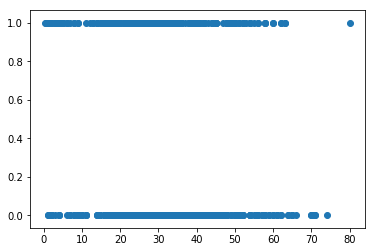

In [112]:
plt.scatter(train_df.Age, train_df[target])

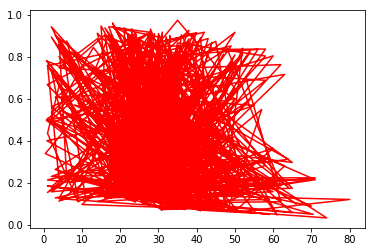

In [113]:
plt.plot(train_df.Age, pred_prob, color='red')

Text(0.5, 0, 'al')

Text(0, 0.5, 'household')

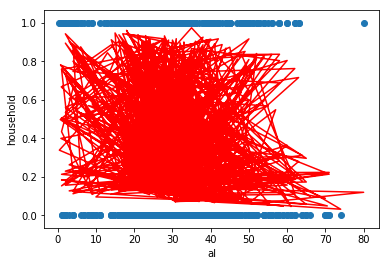

In [115]:
# scatter plot that includes the regression line
plt.scatter(train_df['Age'], train_df[target])
plt.plot(train_df['Age'], pred_prob, color='red')
plt.xlabel('al')
plt.ylabel('household')

In [103]:
def logreg_coef(model,data):    
    """
    Gives the intercepts and coefficients along with variable names for logistic regression.
    model : name of the logistic model
    data :  data on which logistic model was fit, column order must be same as that of the
            data on which model was fit
    """
    intercept = pd.DataFrame({'variable' : 'intercept', 'coefficient' : model.intercept_})
    coefficient = pd.DataFrame({'variable' : data.columns, 'coefficient' : model.coef_.transpose().flatten()})
    coefficient = coefficient.reindex(coefficient.coefficient.abs().sort_values(ascending = False).index)
    return(pd.concat([intercept,coefficient], axis = 0).reset_index(drop = True))

In [105]:
lr_coefs = logreg_coef(model = logreg,data = train_df[features])
lr_coefs.head(10)

,variable,coefficient
0,intercept,0.520690
1,Sex=female,1.075226
2,Sex=male,-1.072737
3,Pclass=3,-0.828703
4,Pclass=1,0.698860
5,SibSp=1,0.398537
6,SibSp=3,-0.303250
7,SibSp=0,0.302043
8,Embarked=S,-0.264339
9,Parch=1,0.243241


##### prediction on test

In [ ]:
pred_test_bin = logreg.predict(test_df[features])
pred_test_prob = logreg.predict_proba(test_df[features])[:,1]
#logreg.score(test_df[features], test_df[target],)

In [85]:
pred_test_bin_sub = np.where(pred_test_prob > 0.42,1,0)#threshold[np.argmax(f_score)],1,0)
np.bincount(pred_test_bin_sub)

array([247, 171], dtype=int64)

In [86]:
# precision_score(test_df[target],pred_bin)
# recall_score(test_df[target],pred_bin)
# confusion_matrix(test_df[target],pred_bin)
# accuracy_score(test_df[target],pred_bin)

In [98]:
test_df.shape
pred_test_bin.shape

(418, 25)

(418,)

In [99]:
pd.concat([test_df[['PassengerId']],pd.DataFrame(pred_test_bin_sub,columns= ['Survived'],index = test_df.index)],axis = 1)\
.to_csv(f'{path}/titanic_submit4.csv', index=False)